# Cross GAN with MINE

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

## Set random seed

In [2]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_rand_seed(37)

## Generate 2_D cross data

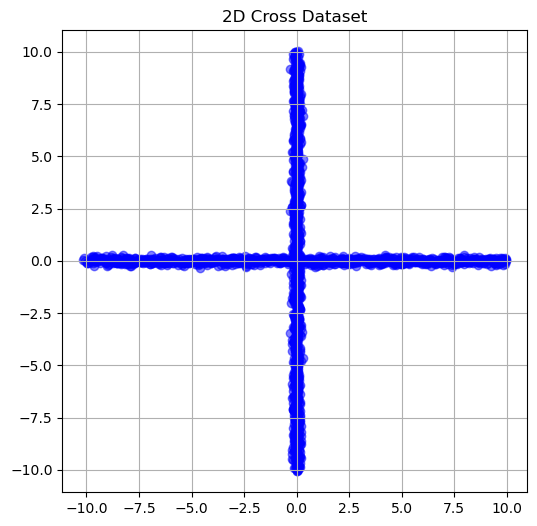

In [3]:
def generate_cross_data(num_samples, noise=0.1):
    """
    Generate 2D cross data (two perpendicular lines with Gaussian noise).

    Args:
        num_samples (int): Total number of data points to generate.
        noise (float): Standard deviation of Gaussian noise added to the data.

    Returns:
        np.ndarray: A 2D array of shape (num_samples, 2) with the cross data.
    """
    num_per_line = num_samples // 2  # Divide samples equally between two lines

    # Generate vertical line data
    x_vertical = np.zeros(num_per_line)  # x-coordinates for vertical line
    y_vertical = np.linspace(-10, 10, num_per_line)  # y-coordinates for vertical line
    vertical_line = np.vstack((
        x_vertical + np.random.normal(0, noise, num_per_line),
        y_vertical + np.random.normal(0, noise, num_per_line)
    )).T

    # Generate horizontal line data
    x_horizontal = np.linspace(-10, 10, num_per_line)  # x-coordinates for horizontal line
    y_horizontal = np.zeros(num_per_line)  # y-coordinates for horizontal line
    horizontal_line = np.vstack((
        x_horizontal + np.random.normal(0, noise, num_per_line),
        y_horizontal + np.random.normal(0, noise, num_per_line)
    )).T

    # Combine vertical and horizontal lines
    return np.vstack((vertical_line, horizontal_line))

# Generate cross data
cross_data = generate_cross_data(2000, noise=0.1)

# Plot the cross data
plt.figure(figsize=(6, 6))
plt.scatter(cross_data[:, 0], cross_data[:, 1], alpha=0.5, c='blue')
plt.title("2D Cross Dataset")
plt.grid(True)
plt.show()

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 2),
            nn.Tanh()
        )

    def forward(self, x):
        return 12 * self.network(x)

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)

## MINE

In [6]:
class MINE(nn.Module):
    def __init__(self, input_dim):
        super(MINE, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x, y):
        """
        Forward pass through the MINE network.

        Args:
            x (torch.Tensor): The first set of variables (e.g., latent variables).
            y (torch.Tensor): The second set of variables (e.g., data representations).

        Returns:
            torch.Tensor: The estimated joint or marginal scores.
        """
        inputs = torch.cat((x, y), dim=1)  # Concatenate inputs along the feature dimension
        return self.network(inputs)

## Training GAN with MINE

In [7]:
n_epochs = 10
lr = 1e-3
batch_size = 64
num_samples = 5000

adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
mine = MINE(input_dim=11)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_MINE = torch.optim.Adam(mine.parameters(), lr=lr, betas=(0.5, 0.9))

Tensor = torch.FloatTensor

# Convert circle_data to PyTorch Tensor and create DataLoader
circle_tensor = torch.tensor(cross_data, dtype=torch.float32)
circle_labels = torch.ones(cross_data.shape[0], 1)
dataset = TensorDataset(circle_tensor, circle_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
def plot_generated_samples(generator, epoch, num_samples=num_samples, latent_dim=10):
    """
    Plot samples generated by the generator model.

    Args:
        generator: The generator model to generate samples.
        epoch: The current epoch number, used for title or saving purposes.
        num_samples: The number of samples to generate.
        latent_dim: The dimensionality of the random noise input to the generator.
    """
    # Generate random noise
    z = torch.randn(num_samples, latent_dim)
    z = z.to(next(generator.parameters()).device)
    # Generate data using the generator
    generated_samples = generator(z).detach().cpu().numpy()

    # Plot the distribution of generated data
    plt.figure(figsize=(6, 6))
    plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, c='red', label="Generated Samples")
    plt.title(f"Generated Samples at Epoch {epoch+1}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [9]:
def train_mine_gan(MI_weight):
    """
    Args:
        MI_weight (float): The weight applied to the mutual information term in the
                           generator's loss function. This controls the trade-off
                           between adversarial loss and mutual information maximization.
    """
    # Lists to store loss values and MI for plotting
    g_loss_history = []
    d_loss_history = []
    mi_history = []

    for epoch in range(n_epochs):
        for i, (x, _) in enumerate(dataloader):
            valid = Variable(Tensor(x.size(0), 1).fill_(1.0), requires_grad=False)  # Real labels
            fake = Variable(Tensor(x.size(0), 1).fill_(0.0), requires_grad=False)  # Fake labels
            z = Variable(Tensor(np.random.normal(0, 1, (x.shape[0], 10))))  # Latent dim = 10
            x_tilde = generator(z)

            # derive MI and train MINE
            optimizer_MINE.zero_grad()
            real_rep = discriminator(x)  # Representation for real samples
            fake_rep = discriminator(x_tilde.detach())  # Representation for generated samples
            joint_score = mine(z, real_rep)  # Joint distribution score
            marginal_score = mine(z, fake_rep)  # Marginal distribution score
            mine_loss = -(torch.mean(joint_score) - torch.log(torch.mean(torch.exp(marginal_score))))
            MI_estimated = -mine_loss.detach()
            mine_loss.backward()
            optimizer_MINE.step()

            # train generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(x_tilde), valid) - MI_weight * MI_estimated  # Weight mutual info by 0.1
            g_loss.backward()
            optimizer_G.step()

            # train discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(x), valid)
            fake_loss = adversarial_loss(discriminator(x_tilde.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # Log losses and MI for this epoch
        g_loss_history.append(g_loss.item())
        d_loss_history.append(d_loss.item())
        mi_history.append(MI_estimated.item())

        if epoch % 1 == 0:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f] [MI (-mine_loss): %f]"
                % (epoch+1, n_epochs, d_loss.item(), g_loss.item(), MI_estimated.item())
            )
            plot_generated_samples(generator, epoch)

    # Plot the recorded losses and MI over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), g_loss_history, label="Generator Loss (G)")
    plt.plot(range(1, n_epochs + 1), d_loss_history, label="Discriminator Loss (D)")
    plt.plot(range(1, n_epochs + 1), mi_history, label="Mutual Information (MI)", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss / MI")
    plt.title("Loss and Mutual Information over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

## Only GAN (w = 0.0)

[Epoch 1/10] [D loss: 0.784555] [G loss: 0.562383] [MI (-mine_loss): 0.031713]


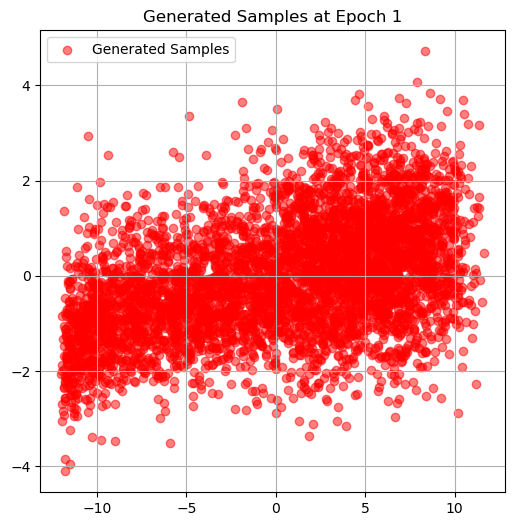

[Epoch 2/10] [D loss: 0.487155] [G loss: 0.831554] [MI (-mine_loss): 1.081703]


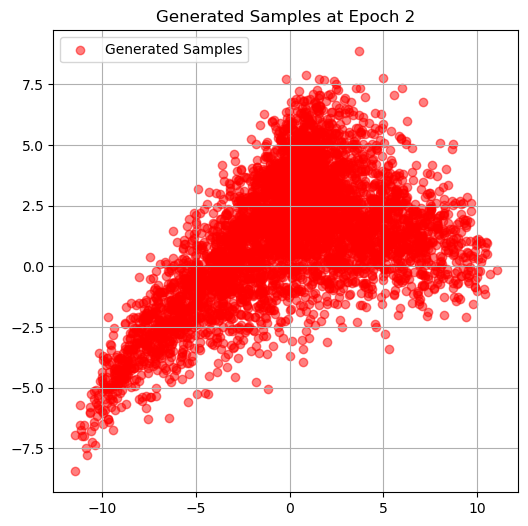

[Epoch 3/10] [D loss: 0.554599] [G loss: 1.252366] [MI (-mine_loss): 1.233494]


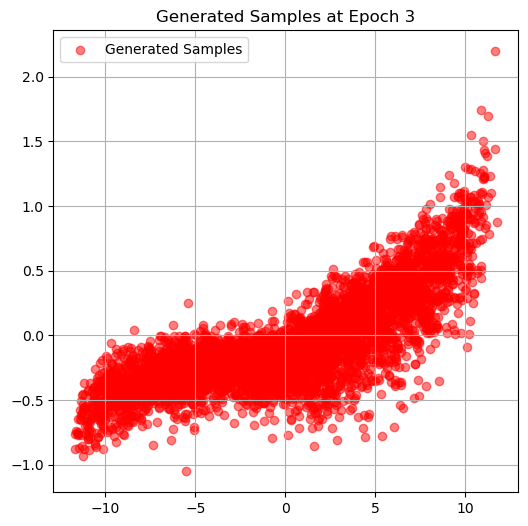

[Epoch 4/10] [D loss: 0.659951] [G loss: 2.070987] [MI (-mine_loss): 1.095389]


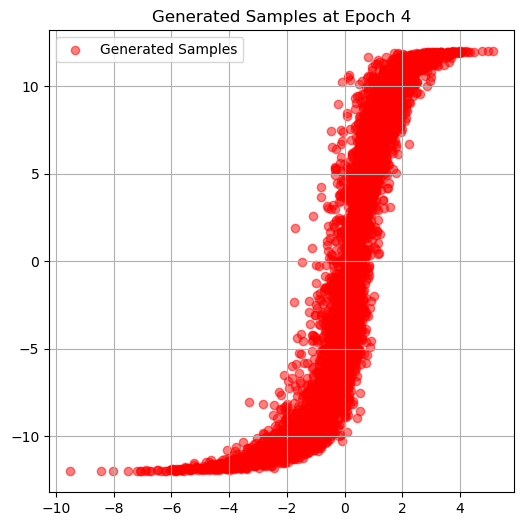

[Epoch 5/10] [D loss: 0.630613] [G loss: 0.795177] [MI (-mine_loss): -0.566307]


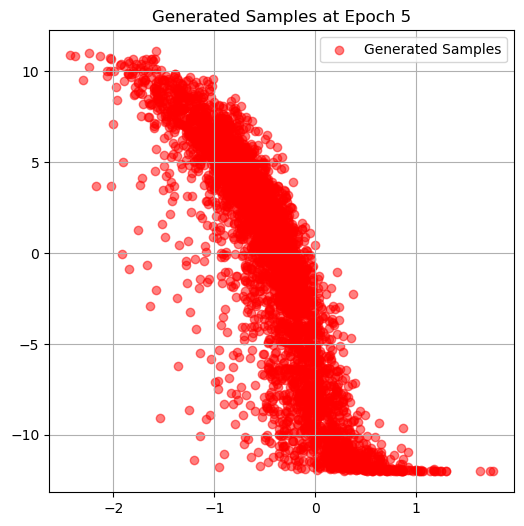

[Epoch 6/10] [D loss: 0.398538] [G loss: 1.009022] [MI (-mine_loss): 4.846569]


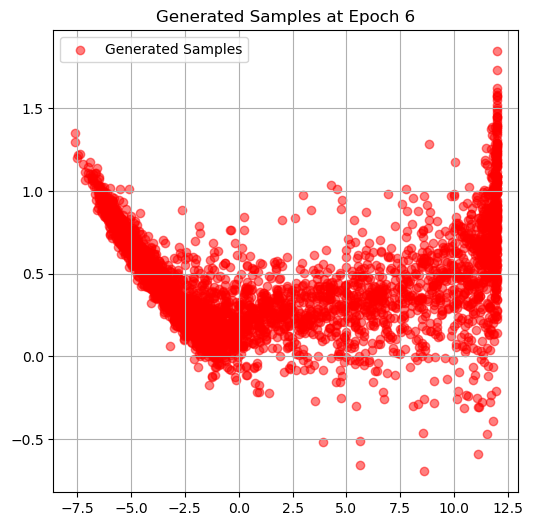

[Epoch 7/10] [D loss: 0.484010] [G loss: 1.139963] [MI (-mine_loss): 4.850342]


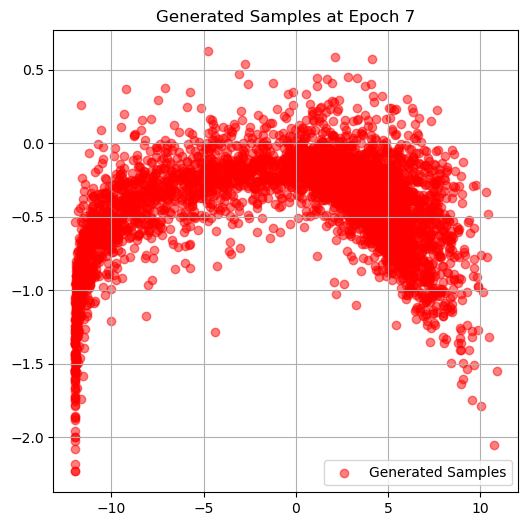

[Epoch 8/10] [D loss: 0.522689] [G loss: 0.862452] [MI (-mine_loss): 1.968560]


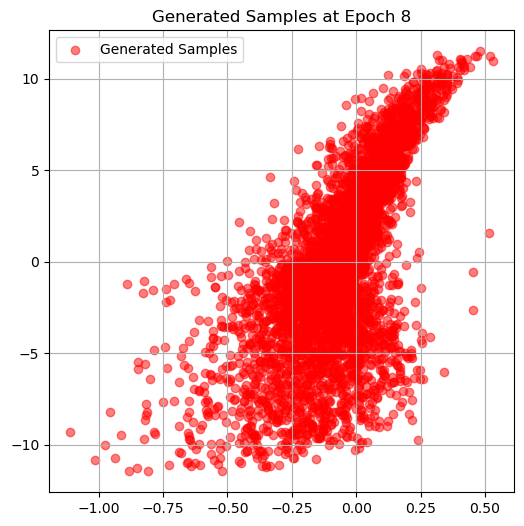

[Epoch 9/10] [D loss: 1.280147] [G loss: 1.160875] [MI (-mine_loss): -12.824702]


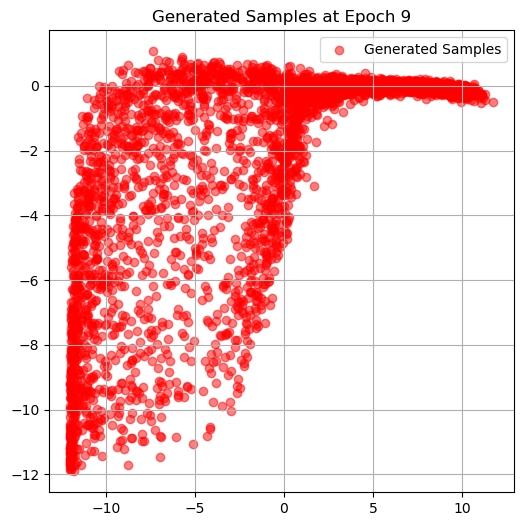

[Epoch 10/10] [D loss: 0.614864] [G loss: 1.239820] [MI (-mine_loss): 3.854845]


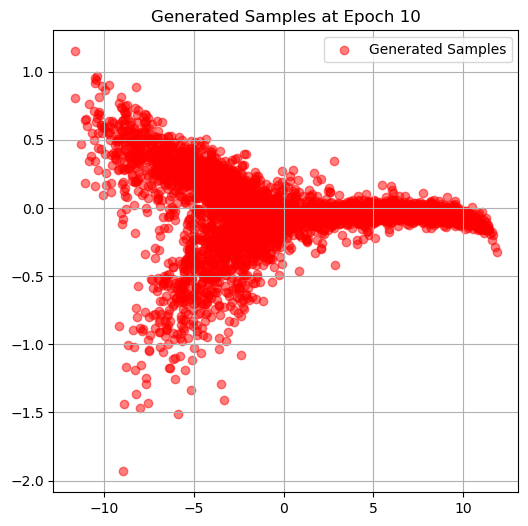

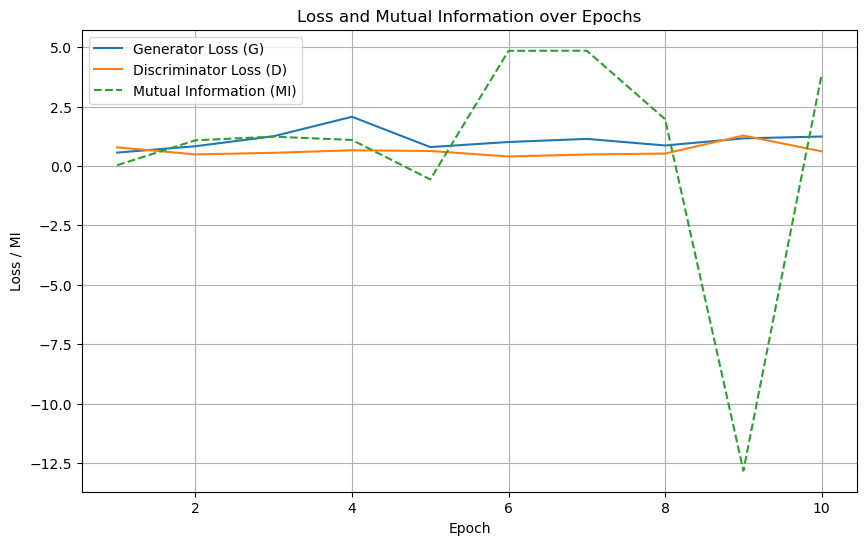

In [10]:
train_mine_gan(MI_weight=0.0)

## w = 1.0

[Epoch 1/10] [D loss: 0.501145] [G loss: -5.927979] [MI (-mine_loss): 6.905159]


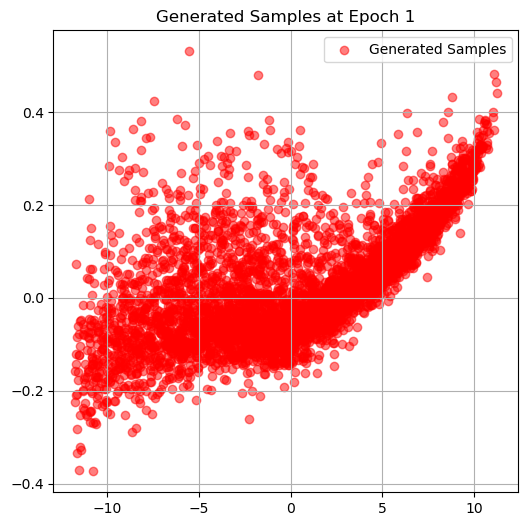

[Epoch 2/10] [D loss: 0.701953] [G loss: 2.251457] [MI (-mine_loss): -1.238010]


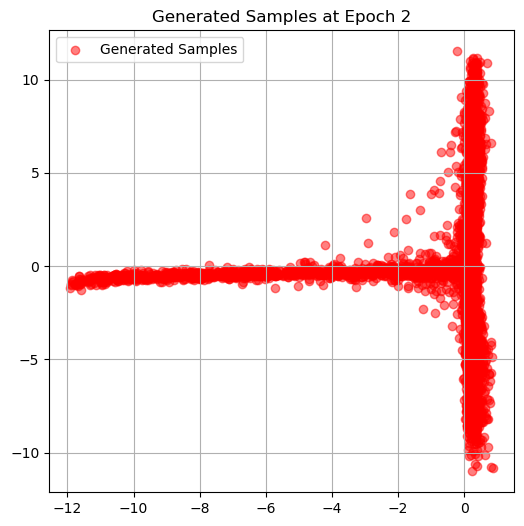

[Epoch 3/10] [D loss: 0.604245] [G loss: -1.326669] [MI (-mine_loss): 2.121989]


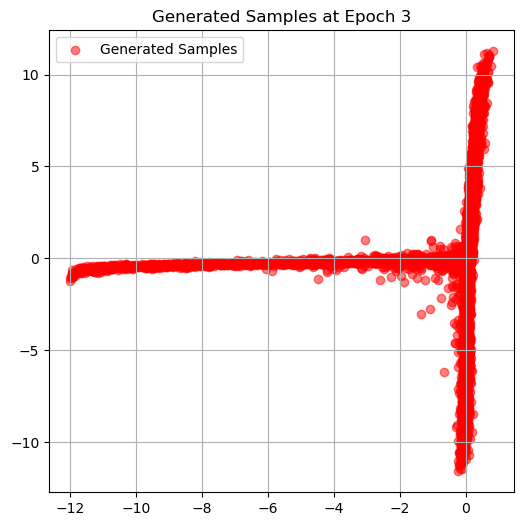

[Epoch 4/10] [D loss: 0.671748] [G loss: 1.298543] [MI (-mine_loss): -0.427591]


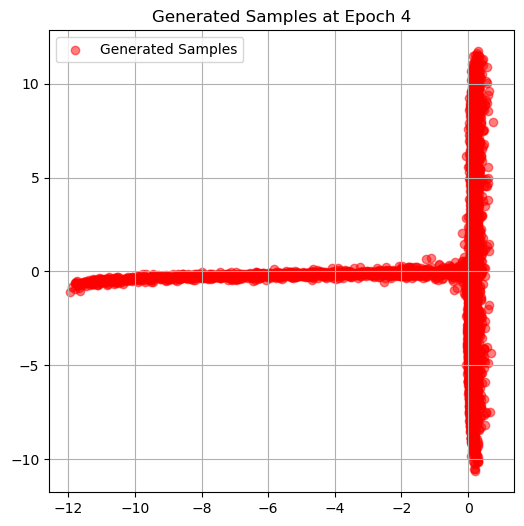

[Epoch 5/10] [D loss: 0.646534] [G loss: 0.127565] [MI (-mine_loss): 0.514567]


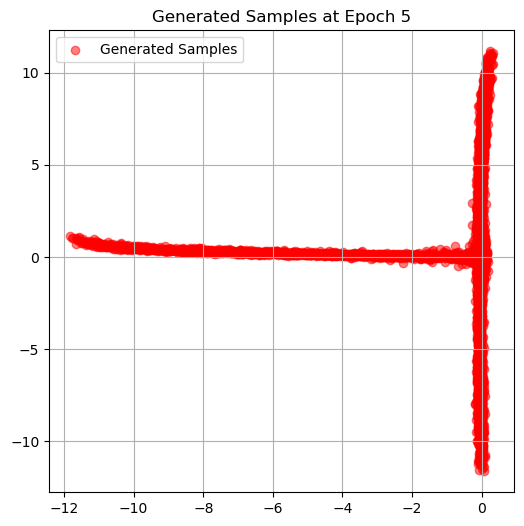

[Epoch 6/10] [D loss: 0.669746] [G loss: 2.104357] [MI (-mine_loss): -1.190449]


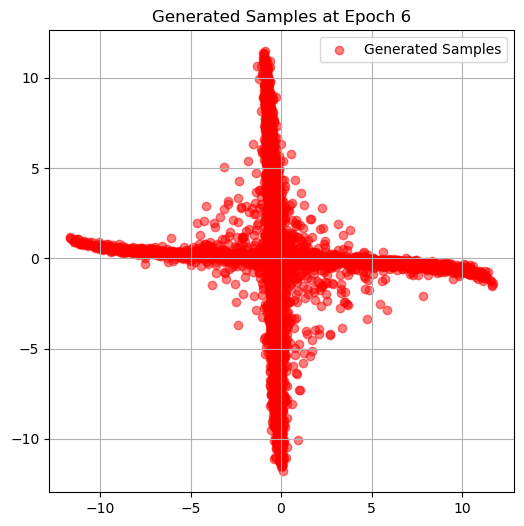

[Epoch 7/10] [D loss: 0.650772] [G loss: 1.450817] [MI (-mine_loss): -0.716186]


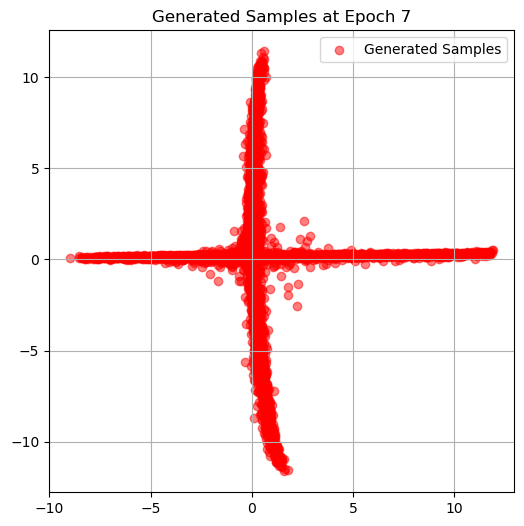

[Epoch 8/10] [D loss: 0.671309] [G loss: 0.731567] [MI (-mine_loss): 0.034230]


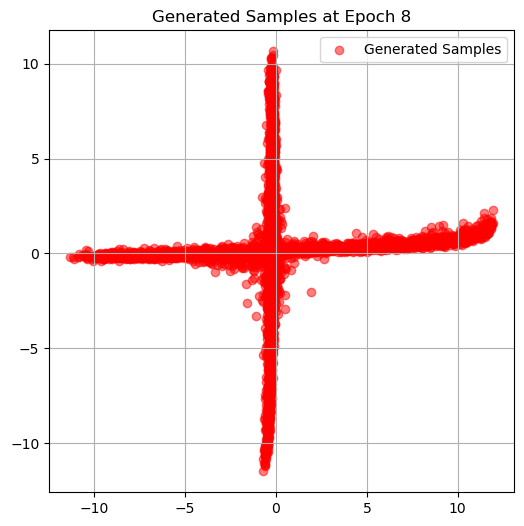

[Epoch 9/10] [D loss: 0.703071] [G loss: 0.903002] [MI (-mine_loss): -0.131879]


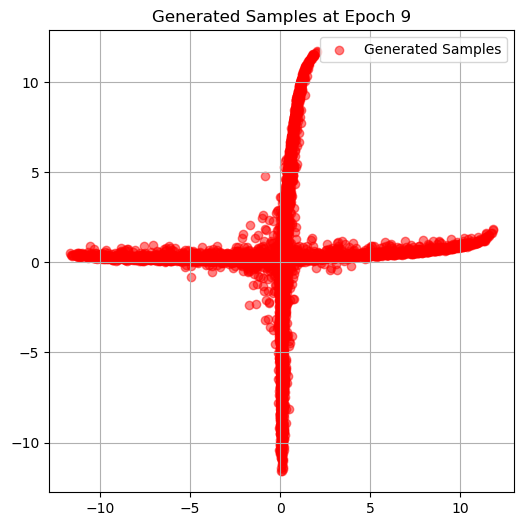

[Epoch 10/10] [D loss: 0.691709] [G loss: 0.675123] [MI (-mine_loss): -0.007719]


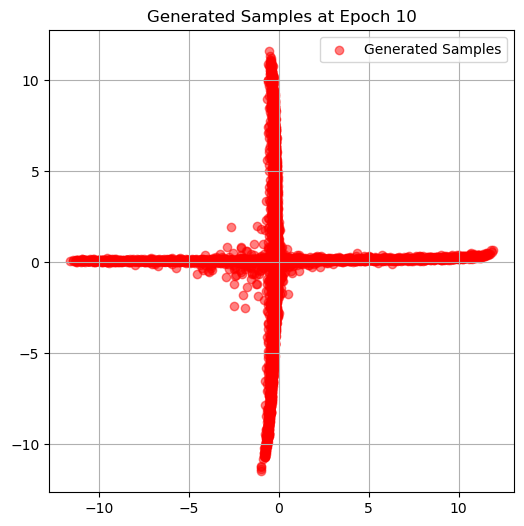

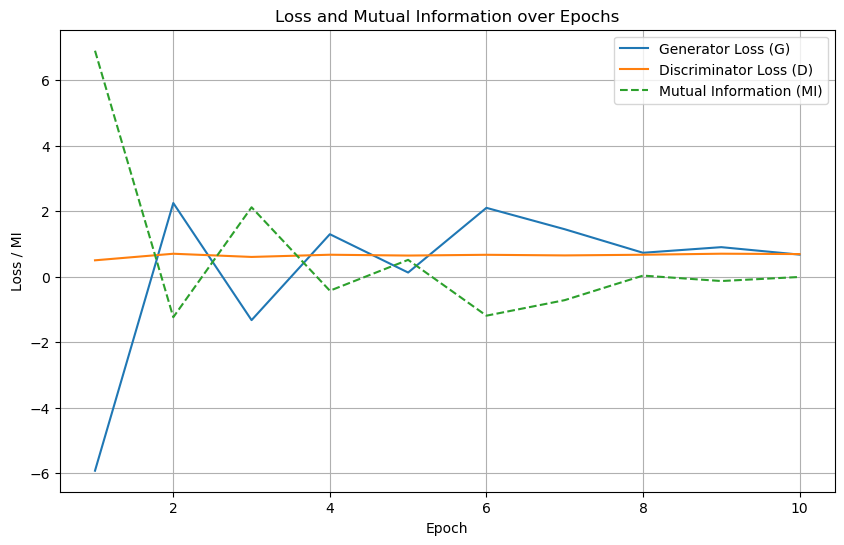

In [11]:
train_mine_gan(MI_weight=1.0)

## w = 0.1

[Epoch 1/10] [D loss: 0.691274] [G loss: 0.710479] [MI (-mine_loss): 0.032733]


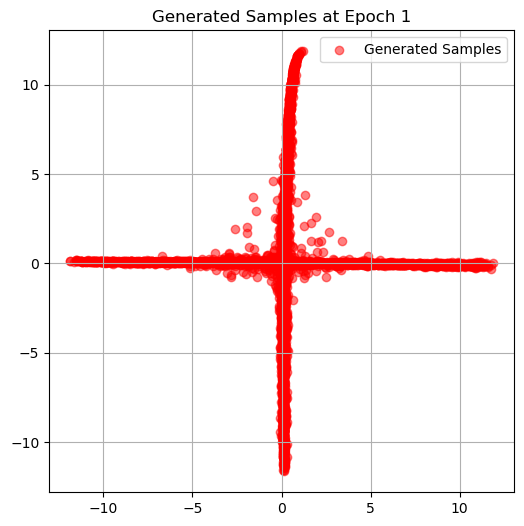

[Epoch 2/10] [D loss: 0.631393] [G loss: 0.715290] [MI (-mine_loss): 0.147341]


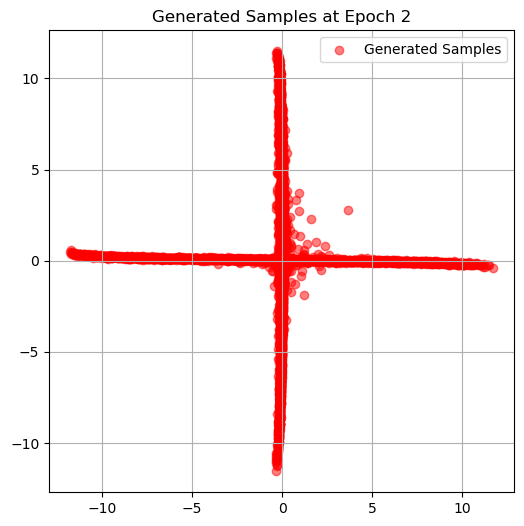

[Epoch 3/10] [D loss: 0.719742] [G loss: 0.603374] [MI (-mine_loss): 0.006781]


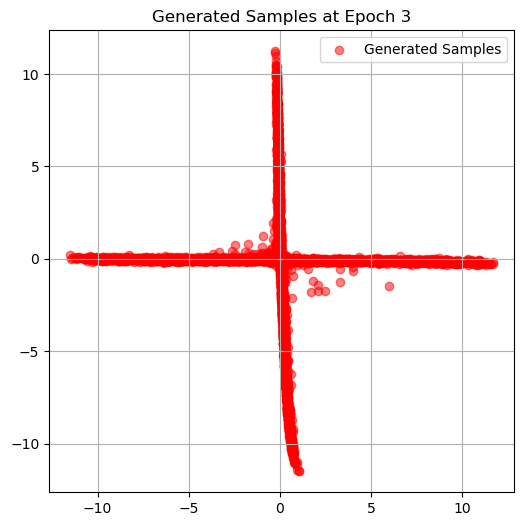

[Epoch 4/10] [D loss: 0.694458] [G loss: 0.747648] [MI (-mine_loss): 0.007433]


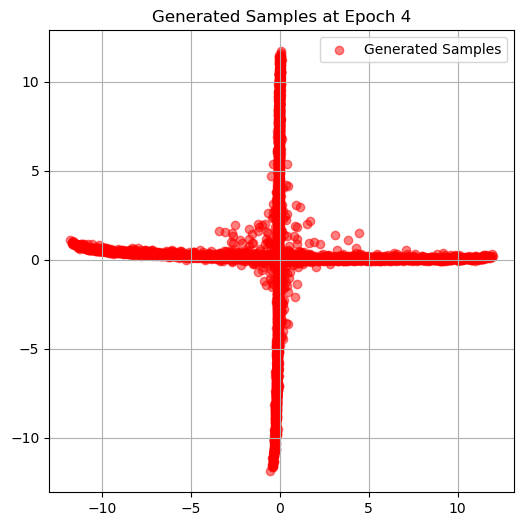

[Epoch 5/10] [D loss: 0.640083] [G loss: 0.770897] [MI (-mine_loss): 0.148524]


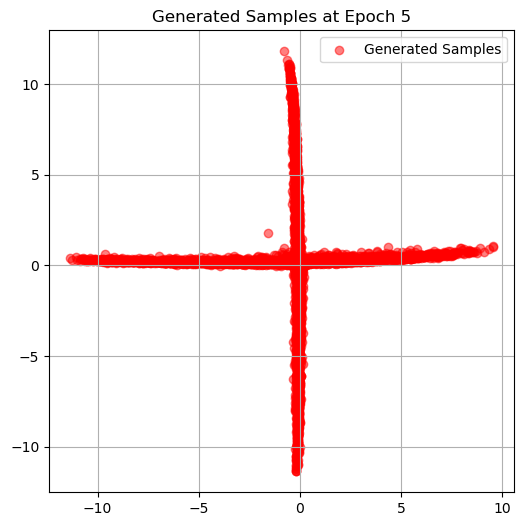

[Epoch 6/10] [D loss: 0.722417] [G loss: 0.700809] [MI (-mine_loss): -0.037063]


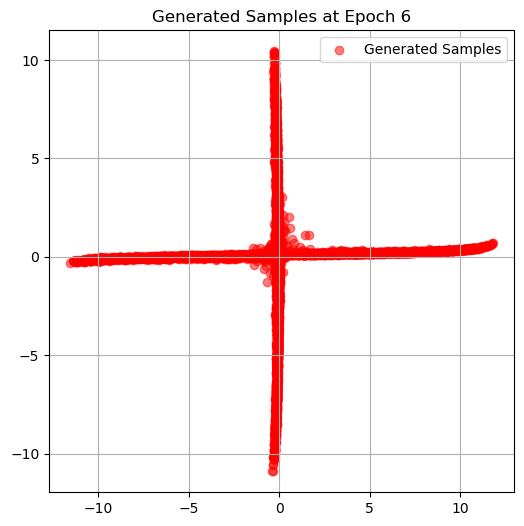

[Epoch 7/10] [D loss: 0.650729] [G loss: 0.626616] [MI (-mine_loss): 0.105999]


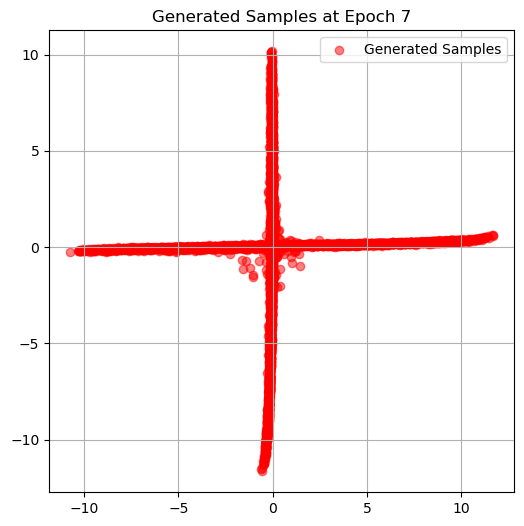

[Epoch 8/10] [D loss: 0.695067] [G loss: 0.757068] [MI (-mine_loss): 0.027131]


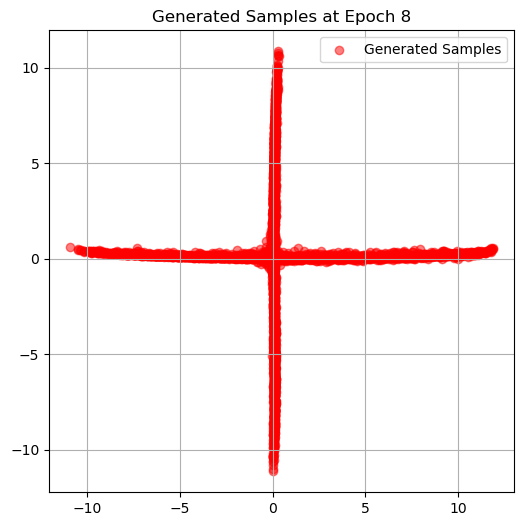

[Epoch 9/10] [D loss: 0.692592] [G loss: 0.651458] [MI (-mine_loss): 0.009555]


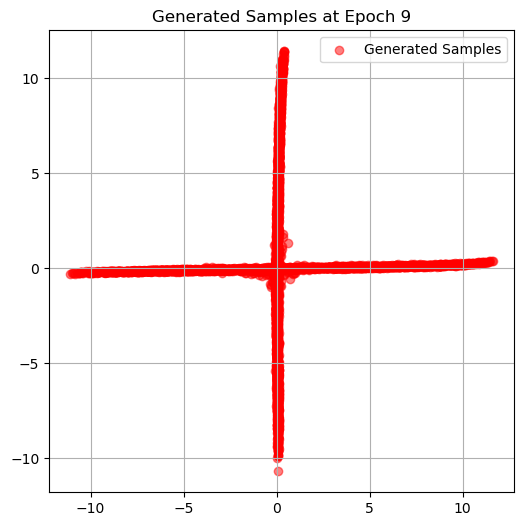

[Epoch 10/10] [D loss: 0.720542] [G loss: 0.727957] [MI (-mine_loss): -0.029033]


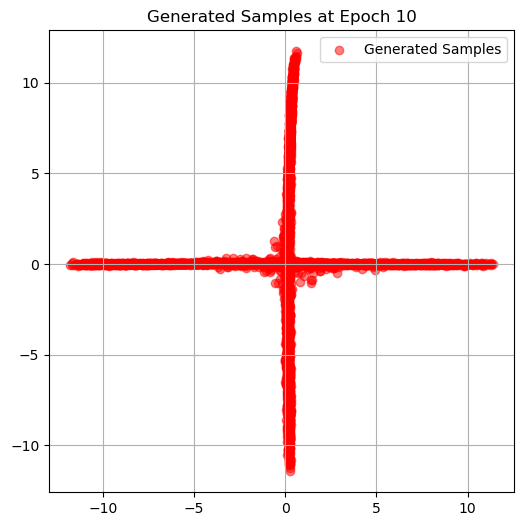

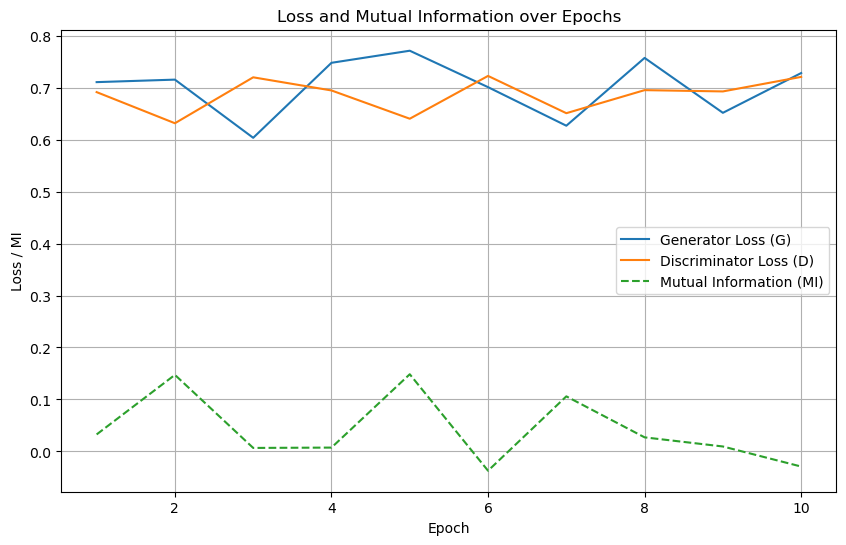

In [12]:
train_mine_gan(MI_weight=0.1)

## w = 0.01

[Epoch 1/10] [D loss: 0.737673] [G loss: 0.734784] [MI (-mine_loss): -0.039291]


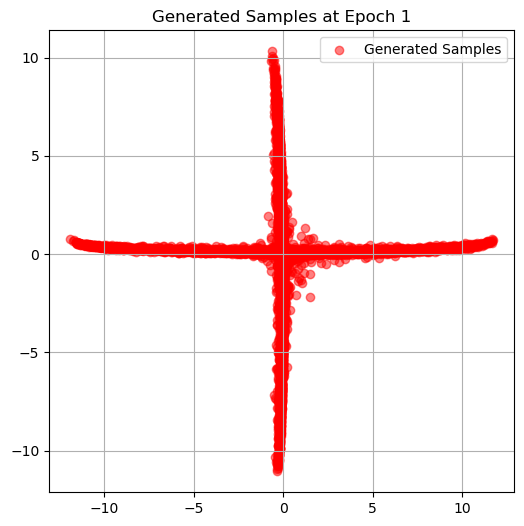

[Epoch 2/10] [D loss: 0.668186] [G loss: 0.687690] [MI (-mine_loss): 0.037057]


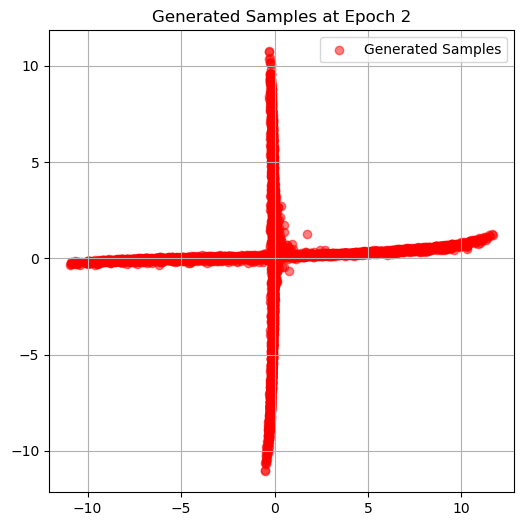

[Epoch 3/10] [D loss: 0.712781] [G loss: 0.697683] [MI (-mine_loss): -0.020952]


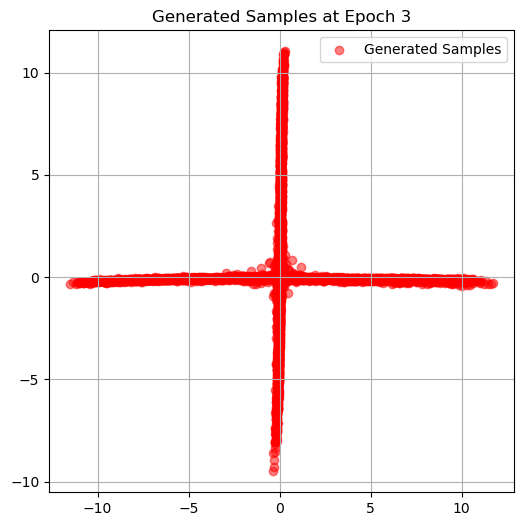

[Epoch 4/10] [D loss: 0.718586] [G loss: 0.651933] [MI (-mine_loss): -0.012392]


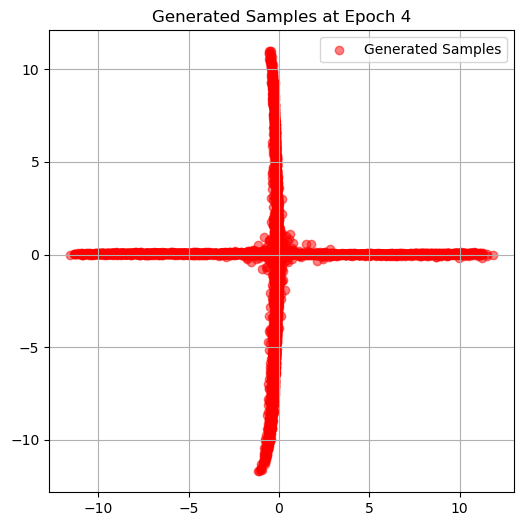

[Epoch 5/10] [D loss: 0.661998] [G loss: 0.774193] [MI (-mine_loss): 0.040790]


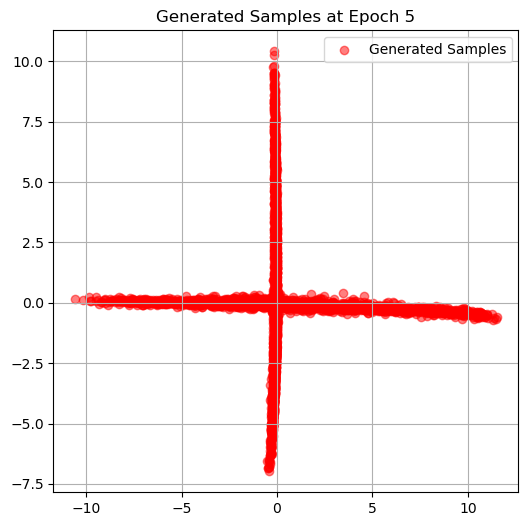

[Epoch 6/10] [D loss: 0.658414] [G loss: 0.760798] [MI (-mine_loss): 0.047664]


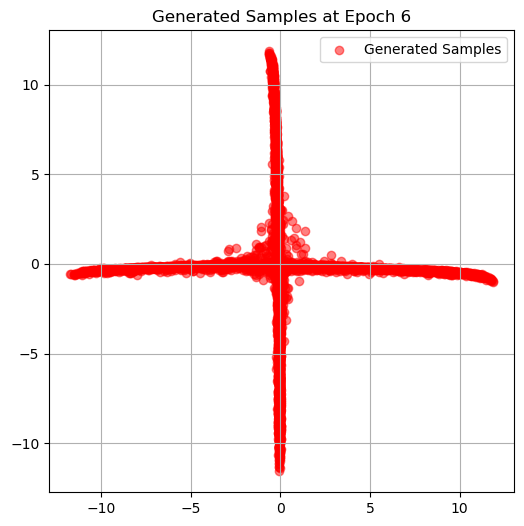

[Epoch 7/10] [D loss: 0.683289] [G loss: 0.821178] [MI (-mine_loss): 0.014082]


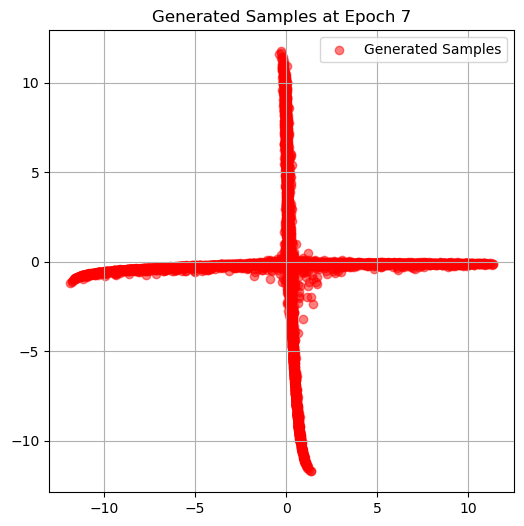

[Epoch 8/10] [D loss: 0.696174] [G loss: 0.741275] [MI (-mine_loss): -0.004421]


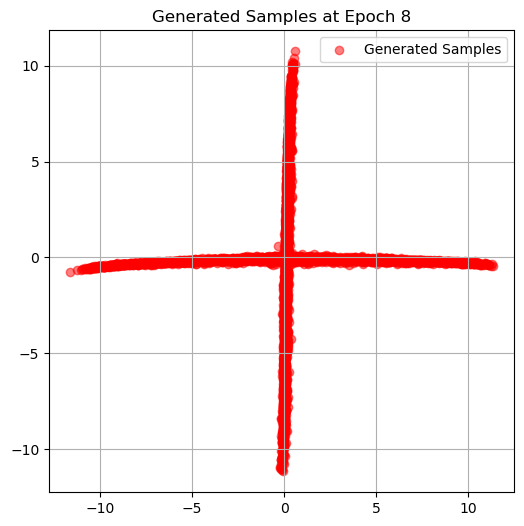

[Epoch 9/10] [D loss: 0.723705] [G loss: 0.645100] [MI (-mine_loss): -0.023624]


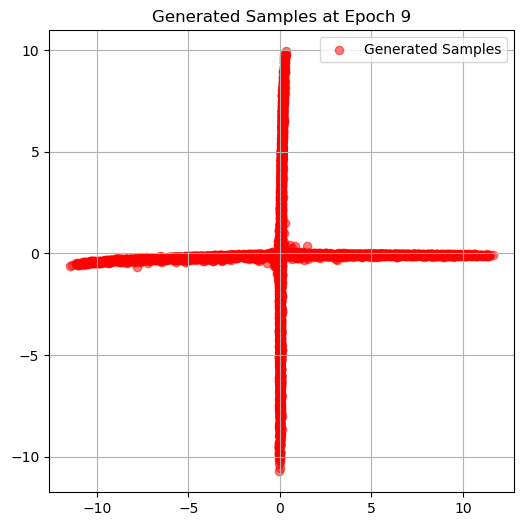

[Epoch 10/10] [D loss: 0.708303] [G loss: 0.724936] [MI (-mine_loss): -0.017616]


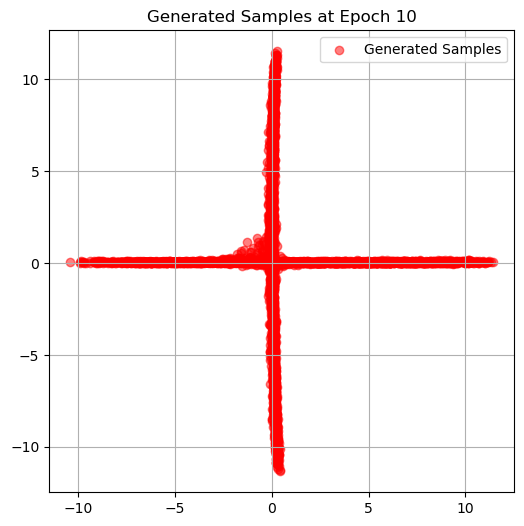

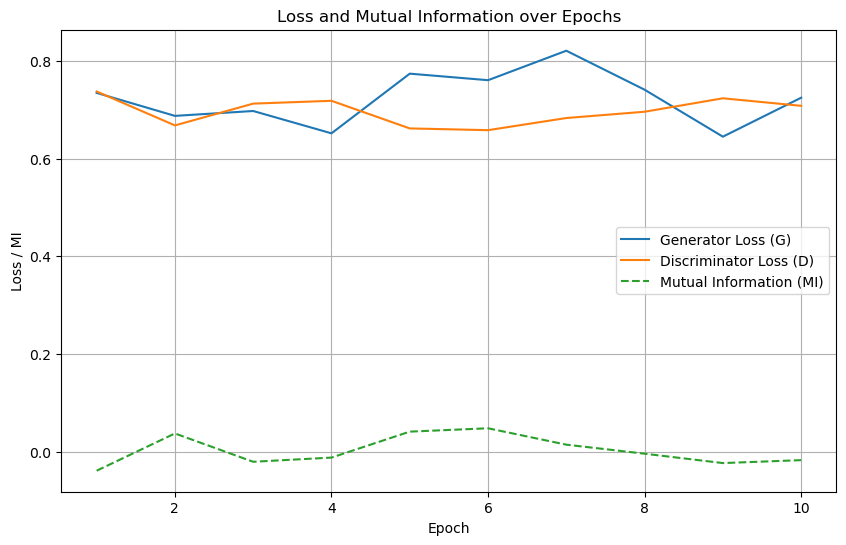

In [13]:
train_mine_gan(MI_weight=0.01)

## w = 0.001

[Epoch 1/10] [D loss: 0.676649] [G loss: 0.790032] [MI (-mine_loss): 0.051063]


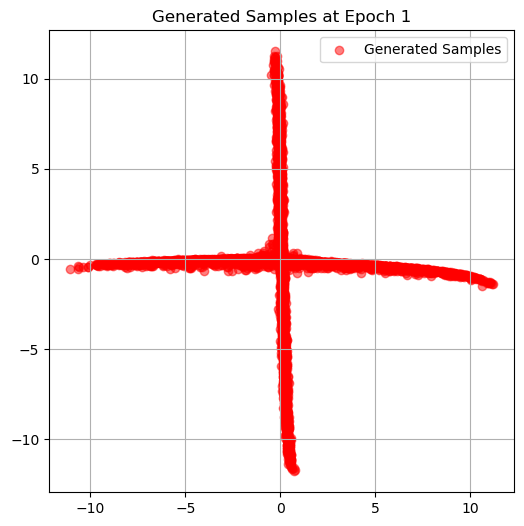

[Epoch 2/10] [D loss: 0.737126] [G loss: 0.762648] [MI (-mine_loss): -0.027994]


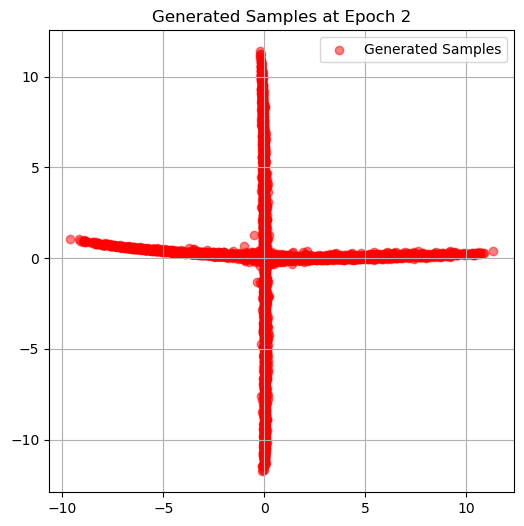

[Epoch 3/10] [D loss: 0.684046] [G loss: 0.654388] [MI (-mine_loss): 0.021286]


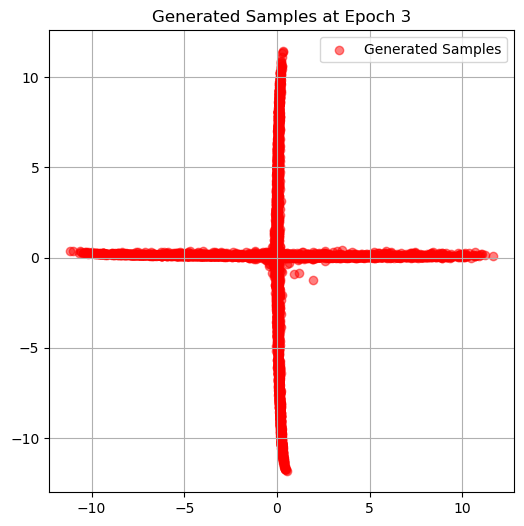

[Epoch 4/10] [D loss: 0.702033] [G loss: 0.616930] [MI (-mine_loss): -0.009856]


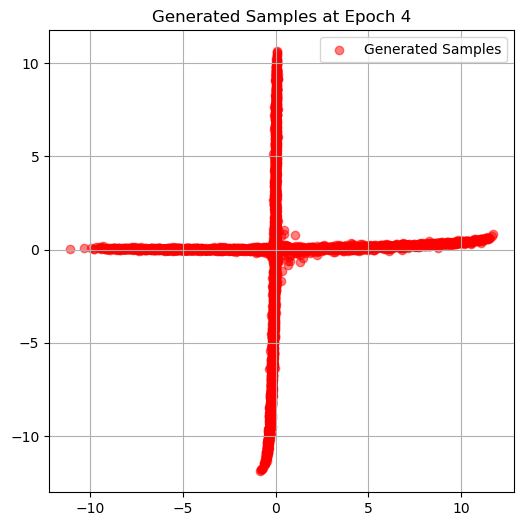

[Epoch 5/10] [D loss: 0.707485] [G loss: 0.650083] [MI (-mine_loss): -0.026420]


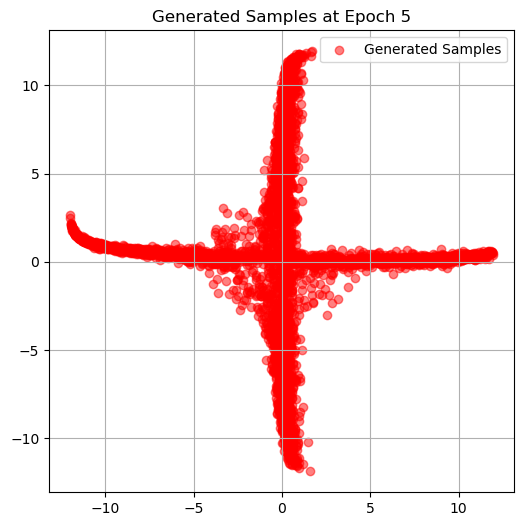

[Epoch 6/10] [D loss: 0.706886] [G loss: 0.607974] [MI (-mine_loss): 0.010994]


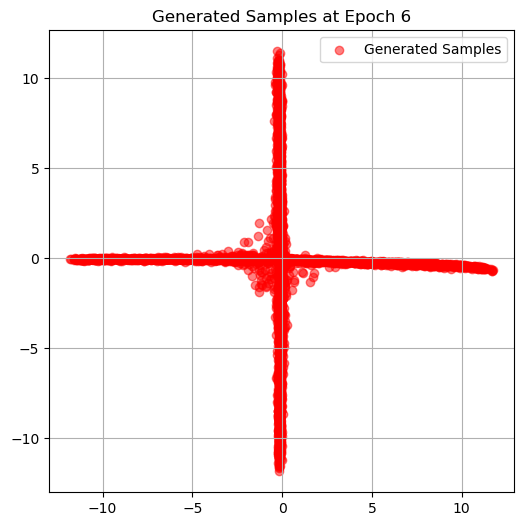

[Epoch 7/10] [D loss: 0.685716] [G loss: 0.699230] [MI (-mine_loss): 0.027280]


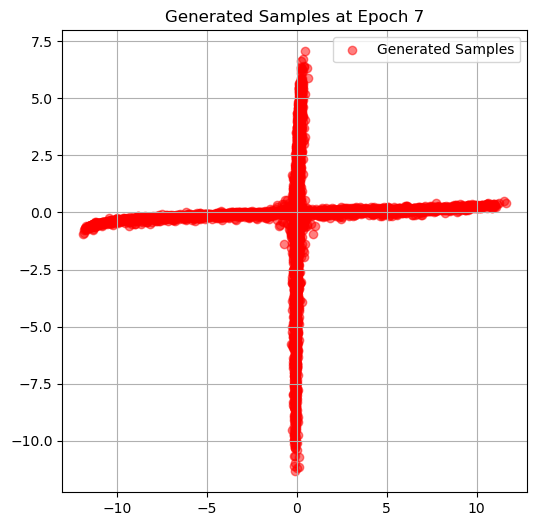

[Epoch 8/10] [D loss: 0.688642] [G loss: 0.786156] [MI (-mine_loss): 0.012304]


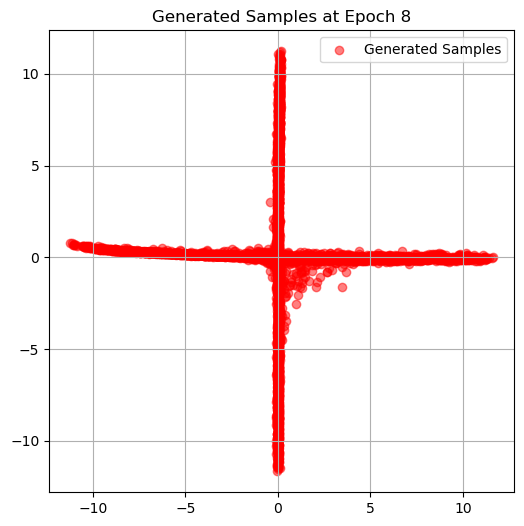

[Epoch 9/10] [D loss: 0.659400] [G loss: 0.749049] [MI (-mine_loss): 0.067891]


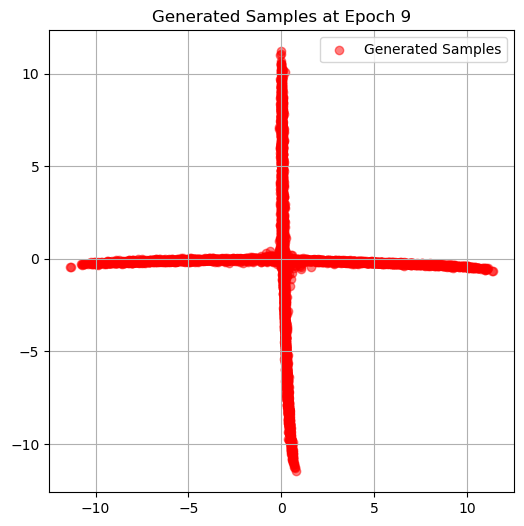

[Epoch 10/10] [D loss: 0.675084] [G loss: 0.830618] [MI (-mine_loss): 0.017218]


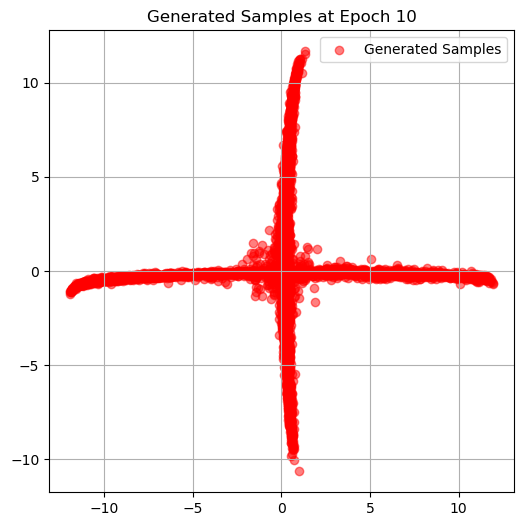

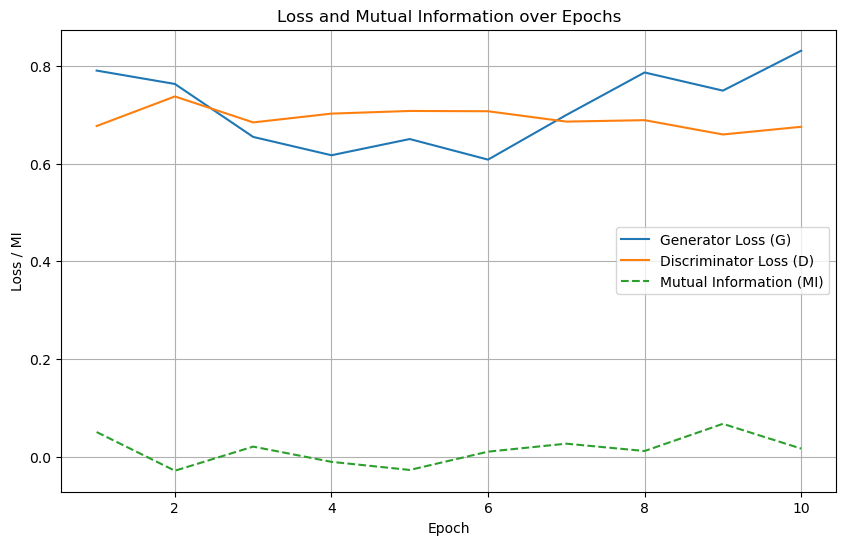

In [14]:
train_mine_gan(MI_weight=0.001)